In [1]:
!pip install pandas
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]2m3/4 [pandas]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


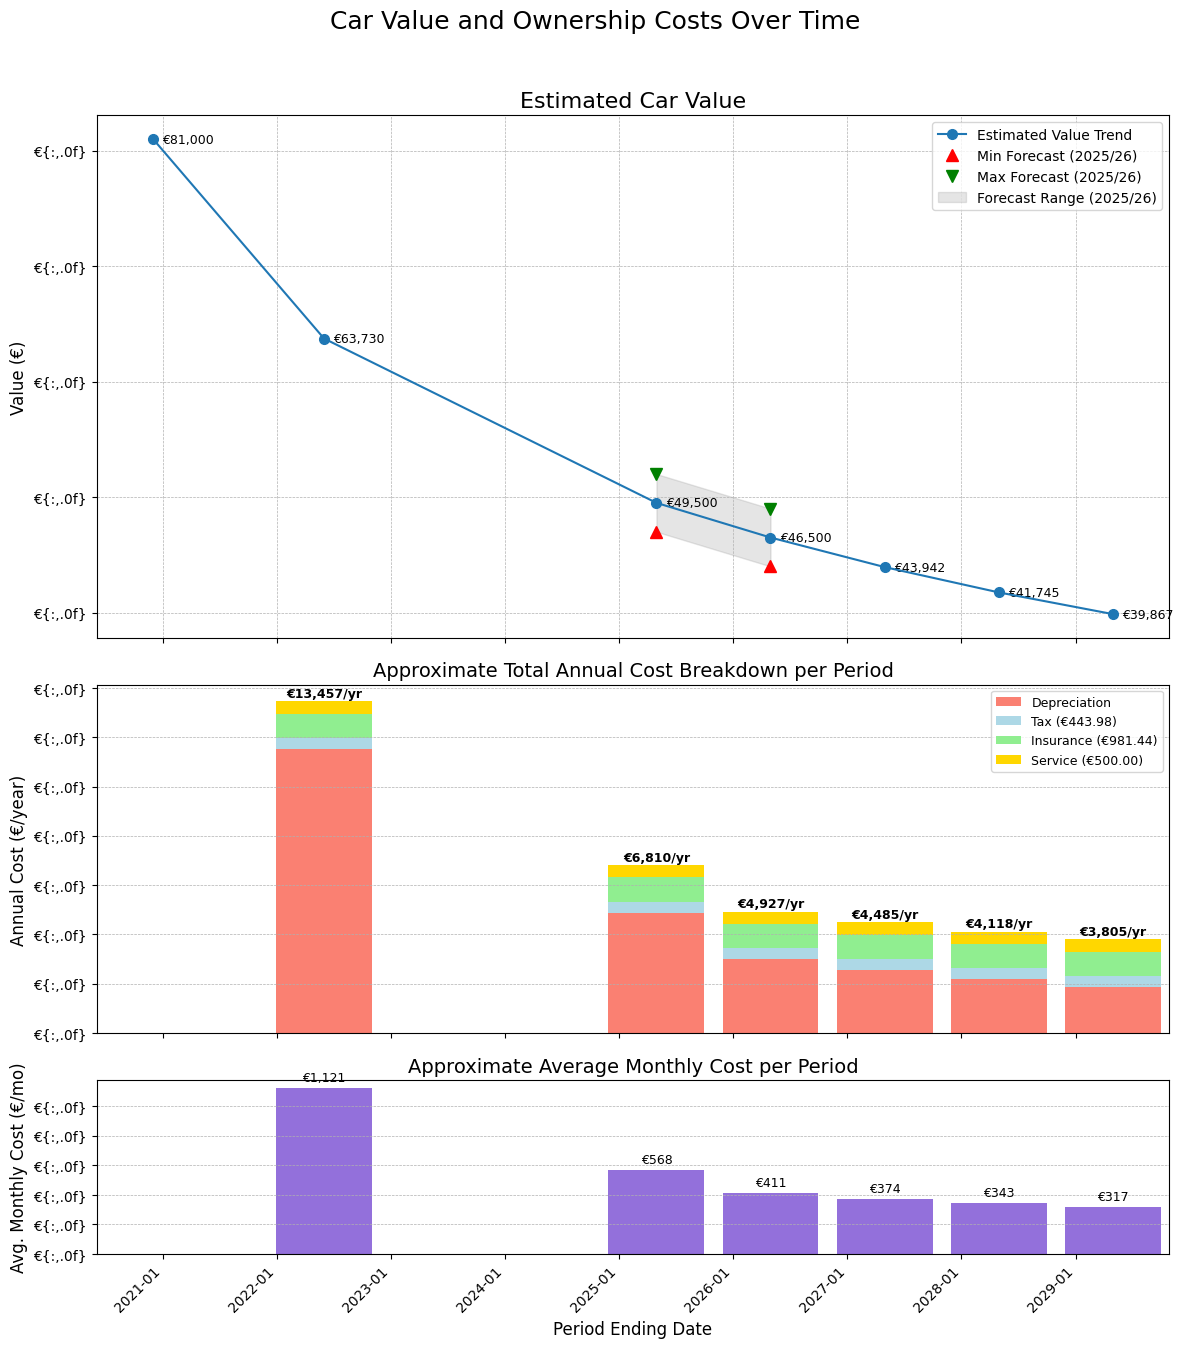


Data with Calculated Costs:
  Period End Date  Annual Depreciation (€)  Annual Tax (€)  \
1      2022-06-01                 11531.51          443.98   
2      2025-04-30                  4884.78          443.98   
3      2026-04-30                  3001.99          443.98   
4      2027-04-30                  2559.20          443.98   
5      2028-04-30                  2192.57          443.98   
6      2029-04-30                  1879.80          443.98   

   Annual Insurance (€)  Annual Service/Repairs (€)  Total Annual Cost (€)  \
1                981.44                       500.0               13456.93   
2                981.44                       500.0                6810.20   
3                981.44                       500.0                4927.41   
4                981.44                       500.0                4484.62   
5                981.44                       500.0                4117.99   
6                981.44                       500.0                3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np # Needed for NaN handling

# --- User Defined Fixed Annual Costs ---
ANNUAL_TAX = 443.98
ANNUAL_INSURANCE = 981.44
ANNUAL_SERVICE_REPAIRS = 500.00
TOTAL_FIXED_COSTS = ANNUAL_TAX + ANNUAL_INSURANCE + ANNUAL_SERVICE_REPAIRS

# --- Data Preparation ---
# Define the data based on user input and extrapolation
data = {
    'Date': pd.to_datetime(['2020-12-01', '2022-06-01', '2025-04-30', '2026-04-30', '2027-04-30', '2028-04-30', '2029-04-30']),
    'Value Type': ['Actual', 'Actual', 'Midpoint', 'Midpoint', 'Estimated', 'Estimated', 'Estimated'],
    'Value (€)': [81000.00, 63730.00, 49500.00, 46500.00, 43942.50, 41745.38, 39866.83],
    'Min (€)': [np.nan, np.nan, 47000.00, 44000.00, np.nan, np.nan, np.nan], # Use np.nan for consistency
    'Max (€)': [np.nan, np.nan, 52000.00, 49000.00, np.nan, np.nan, np.nan]
}
df = pd.DataFrame(data)
df = df.sort_values(by='Date').reset_index(drop=True) # Ensure data is sorted by date

# --- Calculate Annual Loss (Depreciation) ---
# Calculate difference from the *previous* row
df['Value Loss'] = -df['Value (€)'].diff() # Loss = Previous Value - Current Value
df['Time Diff'] = df['Date'].diff()
# Calculate time difference in years (more accurate than assuming 365 days)
df['Time Diff (Years)'] = df['Time Diff'].dt.total_seconds() / (365.2425 * 24 * 60 * 60)
df['Annual Depreciation (€)'] = df['Value Loss'] / df['Time Diff (Years)'] # Renamed for clarity
df['Annual Depreciation (€)'] = pd.to_numeric(df['Annual Depreciation (€)'], errors='coerce') # Ensure numeric

# Prepare data for the bar chart (ignore the first row with NaN)
cost_df = df.iloc[1:].copy()
# Use the end date of the period for labeling the bar chart
cost_df['Period End Date'] = cost_df['Date']

# Add fixed costs and calculate total/monthly costs
cost_df['Annual Tax (€)'] = ANNUAL_TAX
cost_df['Annual Insurance (€)'] = ANNUAL_INSURANCE
cost_df['Annual Service/Repairs (€)'] = ANNUAL_SERVICE_REPAIRS
cost_df['Total Annual Cost (€)'] = cost_df['Annual Depreciation (€)'] + TOTAL_FIXED_COSTS
# Calculate Average Monthly Cost
cost_df['Average Monthly Cost (€)'] = cost_df['Total Annual Cost (€)'] / 12
# Ensure costs are numeric, filling potential NaNs from calculations with 0 for plotting
cost_df['Annual Depreciation (€)'] = pd.to_numeric(cost_df['Annual Depreciation (€)'], errors='coerce').fillna(0)
cost_df['Total Annual Cost (€)'] = pd.to_numeric(cost_df['Total Annual Cost (€)'], errors='coerce').fillna(0)
cost_df['Average Monthly Cost (€)'] = pd.to_numeric(cost_df['Average Monthly Cost (€)'], errors='coerce').fillna(0)


# --- Plotting ---

# Create figure and THREE subplots (one above the other)
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    figsize=(12, 14), # Increased height for third plot
    sharex=True,      # Link the x-axes
    gridspec_kw={'height_ratios': [3, 2, 1]} # Adjust height ratios for 3 plots
)
fig.suptitle('Car Value and Ownership Costs Over Time', fontsize=18, y=0.99) # Add overall title

# --- Plot 1: Depreciation Curve ---
ax1.set_title('Estimated Car Value', fontsize=16)
ax1.set_ylabel('Value (€)', fontsize=12)

# Plot the main trend line
ax1.plot(df['Date'], df['Value (€)'], marker='o', markersize=7, linestyle='-', label='Estimated Value Trend', zorder=5)

# Add Value Labels to the main trend line
for i, row in df.iterrows():
    ax1.text(row['Date'] + pd.Timedelta(days=30), # Offset label slightly
             row['Value (€)'],
             f"€{row['Value (€)']:,.0f}", # Format as currency
             fontsize=9,
             va='center') # Vertical alignment

# Add the Min/Max range for 2025 and 2026
range_dates_df = df.dropna(subset=['Min (€)', 'Max (€)']).copy() # Use rows with valid Min/Max

if not range_dates_df.empty:
     # Plot Min/Max points
     ax1.plot(range_dates_df['Date'], range_dates_df['Min (€)'], 'r^', markersize=8, label='Min Forecast (2025/26)', linestyle='None', zorder=6)
     ax1.plot(range_dates_df['Date'], range_dates_df['Max (€)'], 'gv', markersize=8, label='Max Forecast (2025/26)', linestyle='None', zorder=6)

     # Shade the area between min and max for the range years
     ax1.fill_between(range_dates_df['Date'], range_dates_df['Min (€)'], range_dates_df['Max (€)'], color='gray', alpha=0.2, label='Forecast Range (2025/26)', zorder=1)

# Format Y-axis for Plot 1
formatter_y1 = mticker.FormatStrFormatter('€{:,.0f}')
ax1.yaxis.set_major_formatter(formatter_y1)
ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
ax1.legend(fontsize=10, loc='upper right') # Adjust legend location
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelbottom=False) # Hide x-tick labels for top plot


# --- Plot 2: Total Annual Cost Breakdown (Stacked Bar Chart) ---
ax2.set_title('Approximate Total Annual Cost Breakdown per Period', fontsize=14)
ax2.set_ylabel('Annual Cost (€/year)', fontsize=12)

# Calculate bar width based on average time difference
valid_time_diffs = cost_df['Time Diff'].dropna()
if not valid_time_diffs.empty:
    avg_width_days = valid_time_diffs.mean().days * 0.6
else:
    avg_width_days = 365 * 0.6
bar_width = pd.Timedelta(days=avg_width_days)

# Define the bottom position for each stack
bottom_depreciation = 0
bottom_tax = cost_df['Annual Depreciation (€)']
bottom_insurance = bottom_tax + cost_df['Annual Tax (€)']
bottom_service = bottom_insurance + cost_df['Annual Insurance (€)']

# Create the stacked bars
bars_depreciation = ax2.bar(cost_df['Period End Date'], cost_df['Annual Depreciation (€)'], width=bar_width, label='Depreciation', color='salmon', bottom=bottom_depreciation)
bars_tax = ax2.bar(cost_df['Period End Date'], cost_df['Annual Tax (€)'], width=bar_width, label=f'Tax (€{ANNUAL_TAX:,.2f})', color='lightblue', bottom=bottom_tax)
bars_insurance = ax2.bar(cost_df['Period End Date'], cost_df['Annual Insurance (€)'], width=bar_width, label=f'Insurance (€{ANNUAL_INSURANCE:,.2f})', color='lightgreen', bottom=bottom_insurance)
bars_service = ax2.bar(cost_df['Period End Date'], cost_df['Annual Service/Repairs (€)'], width=bar_width, label=f'Service (€{ANNUAL_SERVICE_REPAIRS:,.2f})', color='gold', bottom=bottom_service)

# Add labels for the TOTAL Annual height of each bar
label_offset_annual = 50 # Base offset for the annual label
for i, row in cost_df.iterrows():
    total_cost = row['Total Annual Cost (€)']
    if pd.notna(total_cost): # Check if total_cost is not NaN
        bar_center_date = row['Period End Date']
        ax2.text(bar_center_date, total_cost + label_offset_annual, # Position label slightly above the bar
                 f"€{total_cost:,.0f}/yr", # Format as currency per year
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

# Format Y-axis for Plot 2
formatter_y2 = mticker.FormatStrFormatter('€{:,.0f}')
ax2.yaxis.set_major_formatter(formatter_y2)
ax2.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
ax2.tick_params(axis='y', labelsize=10)
ax2.legend(fontsize=9, loc='upper right') # Add legend for stacks
ax2.tick_params(axis='x', labelbottom=False) # Hide x-tick labels for middle plot


# --- Plot 3: Average Monthly Cost ---
ax3.set_title('Approximate Average Monthly Cost per Period', fontsize=14)
ax3.set_ylabel('Avg. Monthly Cost (€/mo)', fontsize=12)
ax3.set_xlabel('Period Ending Date', fontsize=12) # X label only on the bottom plot

# Create the monthly cost bar chart
bars_monthly = ax3.bar(cost_df['Period End Date'], cost_df['Average Monthly Cost (€)'],
                       width=bar_width, # Use same width as annual bars
                       label='Avg. Monthly Cost', color='mediumpurple')

# Add labels to the monthly bars
ax3.bar_label(bars_monthly, fmt='€{:,.0f}', padding=3, fontsize=9)

# Format Y-axis for Plot 3
formatter_y3 = mticker.FormatStrFormatter('€{:,.0f}')
ax3.yaxis.set_major_formatter(formatter_y3)
ax3.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
ax3.tick_params(axis='y', labelsize=10)
# ax3.legend(fontsize=9, loc='upper right') # Legend might be redundant here

# --- Common X-axis Formatting ---
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right') # Rotate labels only on bottom plot
min_date = df['Date'].min() - pd.Timedelta(days=180)
max_date = df['Date'].max() + pd.Timedelta(days=180)
ax1.set_xlim(min_date, max_date) # Sets xlim for all shared axes
ax3.tick_params(axis='x', labelsize=10)

# --- Final Adjustments ---
fig.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout rect to prevent title overlap and make space at bottom

# Display the plot
plt.show()

# Optional: Print the dataframe with calculations
print("\nData with Calculated Costs:")
print(cost_df[['Period End Date', 'Annual Depreciation (€)', 'Annual Tax (€)', 'Annual Insurance (€)', 'Annual Service/Repairs (€)', 'Total Annual Cost (€)', 'Average Monthly Cost (€)']].round(2))
